<a href="https://colab.research.google.com/github/psyuktha/skimlit/blob/main/skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 25.66 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# prompt: function to read lines of a document

def get_lines(filename):
  with open(filename, 'r') as f:
    return f.readlines()


In [ ]:
data_dir='content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
train=get_lines('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')

In [ ]:
train[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train)

210040

In [ ]:
def preprocess(filename):
  input=get_lines(filename)
  abstract=''
  abstract_samples=[]
  for i in input:
    if i.startswith("###"):
      astract_id=i
      abstract=''
    elif i.isspace():
      abstract_line_split=abstract.splitlines()
      for line_no,line in enumerate(abstract_line_split):
        line_data={}
        target=line.split("\t")
        line_data['target']=target[0]
        line_data['text']=target[1]
        line_data['line_no']=line_no
        line_data["total_lines"]=len(abstract_line_split)-1
        abstract_samples.append(line_data)
    else:
      abstract+=i

  return abstract_samples





In [ ]:
train_samples=preprocess('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')

In [ ]:
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_no': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_no': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_no': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_no': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Secondary outcome measures included the Western Ontario and McMaster U

In [ ]:
val_samples=preprocess('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')

In [ ]:
test_samples=preprocess('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt')

In [ ]:
len(train_samples),len(val_samples),len(test_samples)

(180040, 30212, 30135)

In [ ]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)


In [ ]:
train_df.head(14)

,target,text,line_no,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,11
6,RESULTS,There was a clinically relevant reduction in t...,6,11
7,RESULTS,The mean difference between treatment arms ( @...,7,11
8,RESULTS,"Further , there was a clinically relevant redu...",8,11
9,RESULTS,These differences remained significant at @ we...,9,11


In [ ]:
train_df['target'].value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

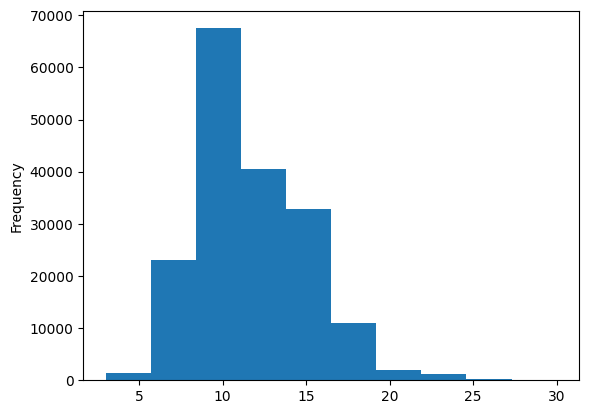

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
train_sentences=train_df['text'].tolist()
val_sentences=val_df['text'].tolist()
test_sentences=test_df['text'].tolist()


In [ ]:
train_sentences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

In [ ]:
import tensorflow as tf

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
one_hot=OneHotEncoder(sparse=False)
train_label_hot=one_hot.fit_transform(tf.expand_dims(train_df['target'],axis=-1))
val_label_hot=one_hot.fit_transform(tf.expand_dims(val_df['target'],axis=-1))
test_label_hot=one_hot.fit_transform(tf.expand_dims(test_df['target'],axis=-1))

train_label_hot[:14]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [ ]:
label_encoder = LabelEncoder()
train_label_encoded=label_encoder.fit_transform(train_df["target"].to_numpy())
val_label_encoded=label_encoder.fit_transform(val_df["target"].to_numpy())
test_label_encoded=label_encoder.fit_transform(test_df["target"].to_numpy())

NameError: name 'train_df' is not defined

In [ ]:
train_label_encoded[:14]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 1, 0, 0])

In [ ]:
class_names=label_encoder.classes_
num_classes=len(class_names)

AttributeError: 'LabelEncoder' object has no attribute 'classes_'

In [ ]:
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),#words to numbers using tfidf
    ("clf", MultinomialNB())#model to text
])

model_0.fit(train_sentences,train_label_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline=model_0.score(val_sentences,val_label_encoded)
baseline*100

72.1832384482987

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-04-16 04:07:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-04-16 04:07:47 (18.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import unzip_data,create_tensorboard_callback, plot_loss_curves, compare_historys,calculate_results

In [ ]:
import numpy as np
from tensorflow.keras import layers


In [ ]:
s=[len(sentence.split()) for sentence in train_sentences]
avg_s=np.mean(s)
avg_s


26.338269273494777

In [ ]:
print(len(train_sentences))

180040


55

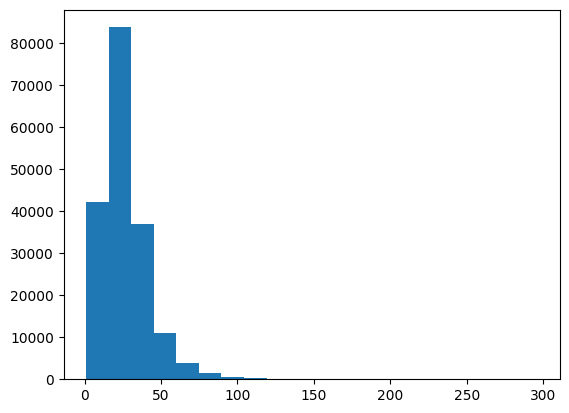

In [ ]:
import matplotlib.pyplot as plt
plt.hist(s,bins=20)
op_len = int(np.percentile(s,95))
op_len

In [ ]:
max_tokens=68000 # taken from table 2 of the paper

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
text_vectorizer = TextVectorization( max_tokens = max_tokens, output_sequence_length=op_len)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
x=random.choice(train_sentences)
print(f"Text {x}")
print(f"length {len(x)}")
x2=text_vectorizer(x)
print(f"Vectorized text {x2} ")

Text The additional survival benefit of ipilimumab plus dacarbazine is maintained with twice as many patients alive at @ years compared with those who initially received placebo plus dacarbazine .
length 191
Vectorized text [   2  365  201  398    4 3852  231 8112   20  863    7  555   25  861
   12 4841   15   64   34    7  125   67 1868   80   48  231 8112    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0] 


In [ ]:
vocab_20 = text_vectorizer.get_vocabulary()
print(f"no of words {len(vocab_20)}")
print(f"common words {vocab_20[:5]}")
print(f"least common words {vocab_20[-5:]}")


no of words 64841
common words ['', '[UNK]', 'the', 'and', 'of']
least common words ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [ ]:
token_embed = layers.Embedding(input_dim=len(vocab_20),
                                             output_dim=128,
                                             mask_zero= True,
                                             name='token_embedding')

In [ ]:
x3=token_embed(x2)
print(f"after embedding {x3}")

after embedding [[ 0.03376187  0.02137187  0.04863746 ...  0.04205697  0.03038296
  -0.01902028]
 [-0.00297351 -0.0190982   0.0260162  ... -0.00139347 -0.02523761
   0.04611026]
 [-0.00632755  0.00062639 -0.04568115 ...  0.02463648  0.03980429
  -0.04821905]
 ...
 [-0.04159246  0.01807454 -0.03220004 ... -0.02005023 -0.04575603
   0.0231619 ]
 [-0.04159246  0.01807454 -0.03220004 ... -0.02005023 -0.04575603
   0.0231619 ]
 [-0.04159246  0.01807454 -0.03220004 ... -0.02005023 -0.04575603
   0.0231619 ]]


turn our data to tensorflow datasets

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_label_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_label_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_label_hot))

In [ ]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
valid_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
inputs=layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x= layers.Conv1D(64, kernel_size = 5, padding='same', activation='relu')(token_embeddings)
x=layers.Flatten()(x)
#x= layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1= tf.keras.Model(inputs,outputs)

In [ ]:
model_1.compile(loss='categorical_crossentropy',
metrics=["accuracy"],
                optimizer=tf.keras.optimizers.Adam()
                )

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 flatten (Flatten)           (None, 3520)              0         
                                                                 
 dense (Dense)               (None, 5)                 17605 

In [ ]:
history_1=model_1.fit(train_dataset,
                      steps_per_epoch=int(0.1*len(train_dataset)),
                                              epochs=3,
                      validation_data=valid_dataset,
                      validation_steps = int(0.1*len(valid_dataset))
                                              )

Epoch 1/3
562/562 [==============================] - 91s 159ms/step - loss: 0.8215 - accuracy: 0.6726 - val_loss: 0.5914 - val_accuracy: 0.7879
Epoch 2/3
562/562 [==============================] - 70s 124ms/step - loss: 0.5861 - accuracy: 0.7863 - val_loss: 0.5698 - val_accuracy: 0.7889
Epoch 3/3
562/562 [==============================] - 71s 127ms/step - loss: 0.5549 - accuracy: 0.7949 - val_loss: 0.5281 - val_accuracy: 0.8045


In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.5315 - accuracy: 0.8054


[0.5315327048301697, 0.8054084181785583]

In [ ]:
preds=model_1.predict(valid_dataset)
preds

945/945 [==============================] - 6s 6ms/step


array([[4.2938629e-01, 3.0628854e-01, 4.7755972e-02, 2.0095919e-01,
        1.5610041e-02],
       [1.3431832e-01, 7.4002171e-01, 1.3058728e-02, 1.0028249e-01,
        1.2318713e-02],
       [1.3703522e-01, 3.4897088e-03, 1.5736027e-03, 8.5743862e-01,
        4.6290623e-04],
       ...,
       [1.7406128e-05, 4.1636237e-04, 3.1119424e-03, 4.6299160e-06,
        9.9644959e-01],
       [3.4375977e-02, 5.8390248e-01, 3.6659282e-02, 3.1373125e-02,
        3.1368914e-01],
       [9.2736250e-03, 9.7115839e-01, 1.2998044e-02, 8.2512008e-04,
        5.7447441e-03]], dtype=float32)

In [ ]:
preds=tf.argmax(preds,axis=1)
preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 1, 1])>

In [ ]:
val_sentences[-1]

'( Funded by AbbVie ; SAPPHIRE-II ClinicalTrials.gov number , NCT@ . )'

In [ ]:
val_label_encoded[-1]

1

In [ ]:
results_1=calculate_results(val_label_encoded,
                            preds)
results_1

{'accuracy': 80.5408446974712,
 'precision': 0.8037946832085446,
 'recall': 0.805408446974712,
 'f1': 0.8043150834999354}

In [ ]:
baseline

0.7218323844829869

model_2:pretrained token embedding

In [ ]:
import tensorflow_hub as hub

embed = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                       trainable = False,
                       name='universal_sentence_encoder')
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings.shape)

# The following are example embedding output of 512 dimensions per sentence
# Embedding for: The quick brown fox jumps over the lazy dog.
# [-0.03133016 -0.06338634 -0.01607501, ...]
# Embedding for: I am a sentence for which I would like to get its embedding.
# [0.05080863 -0.0165243   0.01573782, ...]


(2, 512)


In [ ]:
inputs=layers.Input(shape=[], dtype=tf.string)
embeddings=embed(inputs)
x= layers.Dense(128,activation = 'relu')(embeddings)
outputs=layers.Dense(5,activation='softmax')(x)
model_2=tf.keras.Model(inputs=inputs,
                       outputs=outputs)

model_2.compile(loss='categorical_crossentropy',
metrics=["accuracy"],
                optimizer=tf.keras.optimizers.Adam()
                )

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
history_2=model_2.fit(train_dataset,
                      steps_per_epoch=int(0.1*len(train_dataset)),
                                              epochs=3,
                      validation_data=valid_dataset,
                      validation_steps = int(0.1*len(valid_dataset))
                                              )

Epoch 1/3
562/562 [==============================] - 13s 17ms/step - loss: 0.9145 - accuracy: 0.6485 - val_loss: 0.7979 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7689 - accuracy: 0.7015 - val_loss: 0.7546 - val_accuracy: 0.7055
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7504 - accuracy: 0.7137 - val_loss: 0.7357 - val_accuracy: 0.7168


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.7385 - accuracy: 0.7148


[0.7385026216506958, 0.7148483991622925]

In [ ]:
preds=tf.argmax(model_2.predict(valid_dataset),axis=1)

945/945 [==============================] - 14s 14ms/step


In [ ]:
preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
results_2=calculate_results(val_label_encoded,
                            preds)
results_2

{'accuracy': 71.48484046074407,
 'precision': 0.7153783897013001,
 'recall': 0.7148484046074407,
 'f1': 0.7117188938235683}

In [ ]:
def split_chars(text):
  return ' '.join(list(text))

In [ ]:
train_chars=[split_chars(i) for i in train_sentences]
val_chars=[split_chars(i) for i in val_sentences]
test_chars=[split_chars(i) for i in test_sentences]



In [ ]:
train_chars[:5]

['T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .',
 'A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
char_lens = [len(i) for i in train_sentences]
mean_char_lens=np.mean(char_lens)
mean_char_lens

149.3662574983337

290

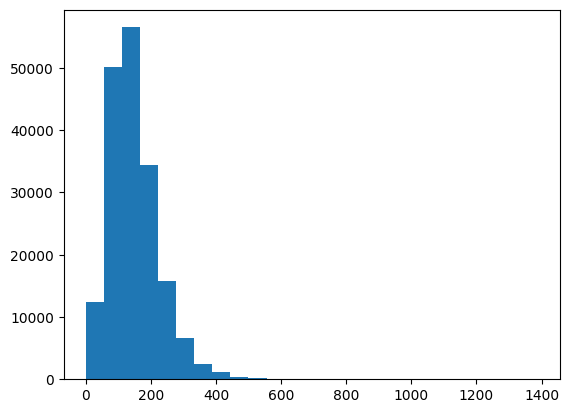

In [ ]:
char_lens = [len(i) for i in train_sentences]
plt.hist(char_lens,bins=25)
perc_len=int(np.percentile(char_lens,95))
perc_len

In [ ]:
#get all keyboard characters
import string
alpha = string.ascii_lowercase + string.digits +string.punctuation

In [ ]:
len(alpha),alpha

(68, 'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

In [ ]:
#create char level tokenisation
num_char_tokens= len(alpha)+2 #space and oov(out of vocab,[UNK])
char_vectorizer=TextVectorization(max_tokens=num_char_tokens,
                                  output_sequence_length=perc_len,
                                  name='char_vectorizer')
#set standardization to None if to include ounctuation marks

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
len(char_vocab)

28

In [ ]:
train_chars[10],char_vectorizer(train_chars[10]),len(train_chars[10].split())

('T h e   O u t c o m e   M e a s u r e s   i n   R h e u m a t o l o g y   C l i n i c a l   T r i a l s - O s t e o a r t h r i t i s   R e s e a r c h   S o c i e t y   I n t e r n a t i o n a l   r e s p o n d e r   r a t e   w a s   @   %   i n   t h e   i n t e r v e n t i o n   g r o u p   a n d   @   %   i n   t h e   p l a c e b o   g r o u p   (   p   <   @   )   .',
 <tf.Tensor: shape=(290,), dtype=int64, numpy=
 array([ 3, 13,  2,  7, 16,  3, 11,  7, 15,  2, 15,  2,  5,  9, 16,  8,  2,
         9,  4,  6,  8, 13,  2, 16, 15,  5,  3,  7, 12,  7, 18, 19, 11, 12,
         4,  6,  4, 11,  5, 12,  3,  8,  4,  5, 12,  9,  7,  9,  3,  2,  7,
         5,  8,  3, 13,  8,  4,  3,  4,  9,  8,  2,  9,  2,  5,  8, 11, 13,
         9,  7, 11,  4,  2,  3, 19,  4,  6,  3,  2,  8,  6,  5,  3,  4,  7,
         6,  5, 12,  8,  2,  9, 14,  7,  6, 10,  2,  8,  8,  5,  3,  2, 20,
         5,  9,  4,  6,  3, 13,  2,  4,  6,  3,  2,  8, 21,  2,  6,  3,  4,
         7,  6, 18,  8,  7, 16, 14,  5,  

In [ ]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                                             output_dim=25,
                                             mask_zero= True,
                                             name='char_embedding')

In [ ]:
inputs=layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x= layers.Conv1D(64, kernel_size = 5, padding='same', activation='relu')(char_embeddings)
#x=layers.Flatten()(x)
x= layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3= tf.keras.Model(inputs,outputs)


model_3.compile(loss='categorical_crossentropy',
metrics=["accuracy"],
                optimizer=tf.keras.optimizers.Adam()
                )

In [ ]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [ ]:
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_label_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_label_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_label_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
history_3=model_3.fit(train_char_dataset,
                      steps_per_epoch=int(0.1*len(train_char_dataset)),
                                              epochs=3,
                      validation_data=val_char_dataset,
                      validation_steps = int(0.1*len(val_char_dataset))
                                              )

Epoch 1/3
562/562 [==============================] - 19s 31ms/step - loss: 1.2516 - accuracy: 0.4790 - val_loss: 1.0449 - val_accuracy: 0.5721
Epoch 2/3
562/562 [==============================] - 14s 25ms/step - loss: 1.0128 - accuracy: 0.5912 - val_loss: 0.9495 - val_accuracy: 0.6124
Epoch 3/3
562/562 [==============================] - 14s 25ms/step - loss: 0.9264 - accuracy: 0.6355 - val_loss: 0.8676 - val_accuracy: 0.6582


In [ ]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.8892 - accuracy: 0.6546


[0.889179527759552, 0.6546405553817749]

In [ ]:
#hybrid embeddings

In [ ]:
token_inputs = layers.Input(shape=(1,),dtype=tf.string, name='token_input')
#token_embed=embed(token_inputs)
token_vectors=text_vectorizer(token_inputs)
token_embeddings=token_embed(token_vectors)
token_output=layers.Dense(128,activation='relu')(token_embeddings)
token_output=layers.Flatten()(token_output)
token_model=tf.keras.Model(inputs=token_inputs,
                           outputs=token_output)

char_inputs = layers.Input(shape=(1,),dtype=tf.string, name='char_input')
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model=tf.keras.Model(inputs=char_inputs,
                           outputs=char_bi_lstm)

token_char_concat=tf.keras.layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                       char_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation='relu')(combined_dropout)
final_dropout=layers.Dropout(0.5)(combined_dense)
output_layer=layers.Dense(num_classes,activation="softmax")(final_dropout)

model_4=tf.keras.Model(inputs=[token_model.input, char_model.input],
                       outputs=output_layer,
                       name='hybrid_model')




In [ ]:
model_4.compile(loss='categorical_crossentropy',
metrics=["accuracy"],
                optimizer=tf.keras.optimizers.Adam()
               )


In [ ]:
model_4.summary()

Model: "hybrid_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 55)                   0         ['token_input[0][0]']         
 ctorization)                                                                                     
                                                                                                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_embedding (Embedding  (None, 55, 128)              8299648   ['text_vectorizatio

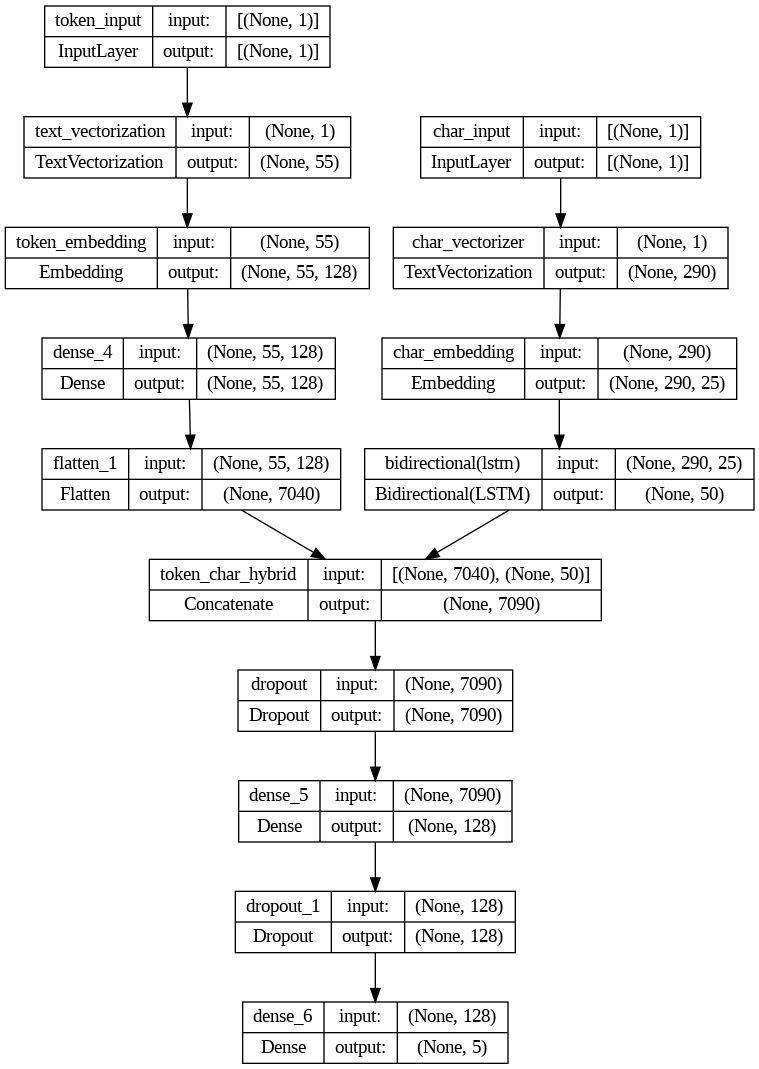

In [ ]:
from keras.utils import plot_model
plot_model(model_4,show_shapes=True)

In [ ]:
#combine chars and tokens into a dataset
train_char_token_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))#make data
train_char_token_label=tf.data.Dataset.from_tensor_slices(train_label_hot)#make labels
train_char_token_dataset=tf.data.Dataset.zip((train_char_token_data,train_char_token_label))

train_char_token_dataset=train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))#make data
val_char_token_label=tf.data.Dataset.from_tensor_slices(val_label_hot)#make labels
val_char_token_dataset=tf.data.Dataset.zip((val_char_token_data,val_char_token_label))

val_char_token_dataset=val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_token_dataset,val_char_token_dataset


(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_4=model_4.fit(train_char_token_dataset,
                      steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                                              epochs=3,
                      validation_data=val_char_token_dataset,
                      validation_steps = int(0.1*len(val_char_token_dataset))
                                              )


Epoch 1/3
562/562 [==============================] - 255s 437ms/step - loss: 0.6343 - accuracy: 0.7677 - val_loss: 0.5907 - val_accuracy: 0.7852
Epoch 2/3
562/562 [==============================] - 235s 418ms/step - loss: 0.4912 - accuracy: 0.8266 - val_loss: 0.6053 - val_accuracy: 0.7716
Epoch 3/3
562/562 [==============================] - 346s 616ms/step - loss: 0.4762 - accuracy: 0.8290 - val_loss: 0.5809 - val_accuracy: 0.7859


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 82s 87ms/step - loss: 0.5878 - accuracy: 0.7835


[0.5878051519393921, 0.7834635376930237]

In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 62s 66ms/step - loss: 0.5878 - accuracy: 0.7835


[0.5878051519393921, 0.7834635376930237]

In [ ]:
results_1

{'accuracy': 80.5408446974712,
 'precision': 0.8037946832085446,
 'recall': 0.805408446974712,
 'f1': 0.8043150834999354}

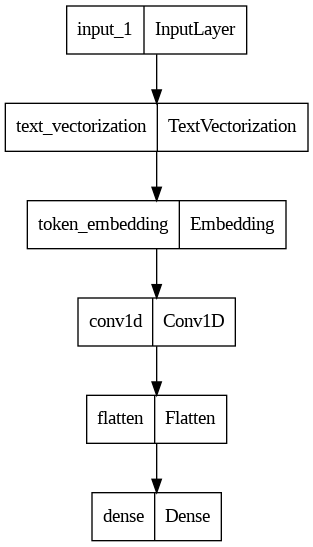

In [ ]:
plot_model(model_1)

In [ ]:
train_df.head()

,target,text,line_no,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11


(array([4.5000e+04, 4.4941e+04, 4.2383e+04, 2.9914e+04, 1.2840e+04,
        3.8000e+03, 9.1000e+02, 2.0000e+02, 4.3000e+01, 9.0000e+00]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <BarContainer object of 10 artists>)

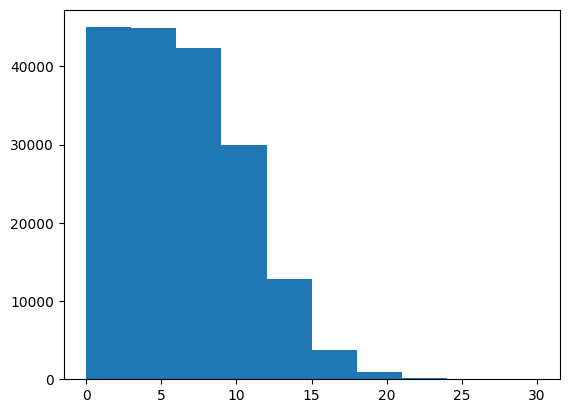

In [ ]:
plt.hist(train_df.line_no)

In [ ]:
#one hot line_no
train_line_hot=tf.one_hot(train_df['line_no'].to_numpy(),depth=15)
val_line_hot=tf.one_hot(val_df['line_no'].to_numpy(),depth=15)
test_line_hot=tf.one_hot(test_df['line_no'].to_numpy(),depth=15)

train_line_hot[:5]

<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
#one hot total lines

(array([ 1393., 23102., 67507., 40551., 32807., 11026.,  2051.,  1223.,
          291.,    89.]),
 array([ 3. ,  5.7,  8.4, 11.1, 13.8, 16.5, 19.2, 21.9, 24.6, 27.3, 30. ]),
 <BarContainer object of 10 artists>)

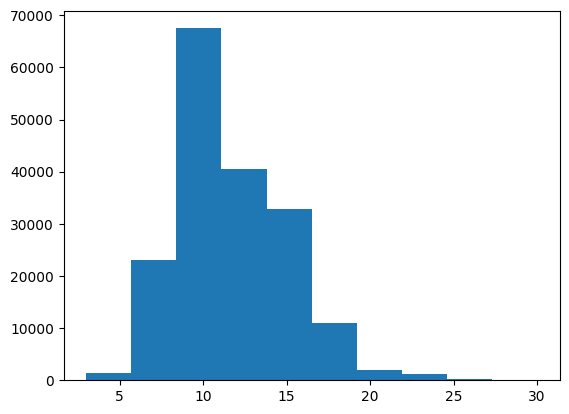

In [ ]:
plt.hist(train_df.total_lines)

In [ ]:
#one hot line_no
train_tot_line_hot=tf.one_hot(train_df['total_lines'].to_numpy(),depth=20)
val_tot_line_hot=tf.one_hot(val_df['total_lines'].to_numpy(),depth=20)
test_tot_line_hot=tf.one_hot(test_df['total_lines'].to_numpy(),depth=20)

train_tot_line_hot[:5]

<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
token_inputs = layers.Input(shape=(1,),dtype=tf.string, name='token_input')
#token_embed=embed(token_inputs)
token_vectors=text_vectorizer(token_inputs)
token_embeddings=token_embed(token_vectors)
token_output=layers.Dense(128,activation='relu')(token_embeddings)
token_output=layers.Flatten()(token_output)
token_model=tf.keras.Model(inputs=token_inputs,
                           outputs=token_output)

char_inputs = layers.Input(shape=(1,),dtype=tf.string, name='char_input')
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(inputs=char_inputs,
                           outputs=char_bi_lstm)

token_char_concat=tf.keras.layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                       char_model.output])


line_no_input=layers.Input(shape=(15,),dtype=tf.float32, name='line_no_ip')
x=layers.Dense(32, activation='relu')(line_no_input)
line_no_model=tf.keras.Model(inputs=line_no_input,
                             outputs=x)

tot_lines_input=layers.Input(shape=(20,),dtype=tf.float32, name='tot_line_ip')
y=layers.Dense(32, activation='relu')(tot_lines_input)
tot_lines_model=tf.keras.Model(inputs=tot_lines_input,
                             outputs=y)

combined_embeddings = layers.Concatenate(name='char_token')([token_model.output,
                                                             char_model.output])

z=layers.Dense(256,activation='relu')(combined_embeddings)
z=layers.Dropout(0.5)(z)

tribrid_embeddings= layers.Concatenate(name='tribrid')([line_no_model.output,
                                                        tot_lines_model.output,
                                                        z])

output_layer=layers.Dense(5,activation='softmax',name='op_layer')(tribrid_embeddings)

model_5 = tf.keras.Model(inputs=[line_no_model.input,tot_lines_model.input,
                                 token_model.input,char_model.input],
                         outputs=output_layer
                         )



In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
metrics=["accuracy"],
                optimizer=tf.keras.optimizers.Adam()
               )



In [ ]:
train_char_token_pos_data= tf.data.Dataset.from_tensor_slices((train_line_hot,
                                                    train_tot_line_hot,
                                                    train_sentences,
                                                    train_chars))

train_char_token_pos_label= tf.data.Dataset.from_tensor_slices(train_label_hot)

train_char_token_pos_dataset= tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_label))
train_char_token_pos_dataset=train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)




In [ ]:
val_char_token_pos_data= tf.data.Dataset.from_tensor_slices((val_line_hot,
                                                    val_tot_line_hot,
                                                    val_sentences,
                                                    val_chars))

val_char_token_pos_label= tf.data.Dataset.from_tensor_slices(val_label_hot)

val_char_token_pos_dataset= tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_label))
val_char_token_pos_dataset=val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)




In [ ]:
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_5=model_5.fit(train_char_token_pos_dataset,
                      steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                                              epochs=3,
                      validation_data=val_char_token_pos_dataset,
                      validation_steps = int(0.1*len(val_char_token_pos_dataset))
                                              )



Epoch 1/3
562/562 [==============================] - 247s 420ms/step - loss: 0.9634 - accuracy: 0.8370 - val_loss: 0.9485 - val_accuracy: 0.8331
Epoch 2/3
562/562 [==============================] - 230s 410ms/step - loss: 0.8649 - accuracy: 0.9012 - val_loss: 0.9376 - val_accuracy: 0.8414
Epoch 3/3
562/562 [==============================] - 225s 401ms/step - loss: 0.8474 - accuracy: 0.9123 - val_loss: 0.9507 - val_accuracy: 0.8182


In [ ]:
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 57s 60ms/step - loss: 0.9433 - accuracy: 0.8244


[0.9433304667472839, 0.824440598487854]

In [ ]:
model_5.save('/content/drive/MyDrive/skimlit')

In [ ]:
loaded_model= tf.keras.models.load_model('/content/drive/MyDrive/skimlit')


NameError: name 'tf' is not defined

import tensorflow as tf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json



--2024-04-17 13:42:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json.1’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-04-17 13:42:01 (69.5 MB/s) - ‘skimlit_example_abstracts.json.1’ saved [6737/6737]



In [ ]:

import json
with open('skimlit_example_abstracts.json' , 'r') as f:
  example_abstracts = json.load(f)

example_abstracts


[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [ ]:

# Extract labels and encoder them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import numpy as np
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
def split_chars(text):
  return ' '.join(list(text))

In [ ]:
def visualize_pred_sequence_labels(abstract_dict , model , label_encoder):

  '''

    Takes in a list of dictionaries of abstracts,

    [{'abstract': 'This RCT examined .......' ,
      'details': 'RCT of a manuali......',
      'source': 'https://pubmed.ncbi.nlm........./'},..........]

    Arguments:
    ----------
      - abstract_dict : Abstract dictionary of the above format
      - model : the trained model on the same data format (line_numbers,  total_lines , sentences , characters)
      - label_encoder : the label encoder used to encode the classes

    Returns:
    --------
      Prints out the predicted label and the corresponding sequence/ text
  '''


  from spacy.lang.en import English
  nlp = English()

  # Create sentence splitting pipeline object
  #sentencizer = nlp.add_pipe('sentencizer')
  nlp.add_pipe('sentencizer')

  # Create doc of parsed sequences
  doc = nlp(abstract_dict)

  # Return detected sentences from doc in string typpe
  abstract_lines = [str(sent) for sent in list(doc.sents)]

  # Get total number of lines
  total_lines_in_sample = len(abstract_lines)

  # Loop through each line in the abstract and create a list of dictionaries containing features
  sample_lines = []
  for i , line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict['text'] = str(line)
    sample_dict['line_number'] = i
    sample_dict['total_lines'] = total_lines_in_sample - 1
    sample_lines.append(sample_dict)


  # Get all line number and total lines numbers then one hot encode them
  abstract_line_numbers = [line['line_number'] for line in sample_lines]
  abstract_total_lines = [line['total_lines'] for line in sample_lines]

  abstract_line_numbers_one_hot = tf.one_hot(abstract_line_numbers , depth = 15)
  abstract_total_lines_one_hot = tf.one_hot(abstract_total_lines , depth = 20)


  # Split the lines into characters
  abstract_chars = [split_chars(sentence) for sentence in abstract_lines]

  # Making prediction on sample features
  abstract_pred_probs = model.predict(x = (abstract_line_numbers_one_hot,
                                           abstract_total_lines_one_hot ,
                                           tf.constant(abstract_lines) ,
                                           tf.constant(abstract_chars)))

  # Turn prediction probs to pred class
  abstract_preds = tf.argmax(abstract_pred_probs , axis = 1)


  classes = ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']

  # Prediction class integers into string class name
  abstract_pred_classes = [classes[i] for i in abstract_preds]

  # Prints out the abstract lines and the predicted sequence labels
  for i , line in enumerate(abstract_lines):
    print(f'{abstract_pred_classes[i]}:  {line}\n')




In [ ]:
text_ = "Double-lumen tubes (DLT) and bronchial blockers (BB) are the most commonly used airway tools in thoracic surgery1. They allow isolation of the operative lung from the non-operative lung, which prevents contamination of the non-operative lung by pollutants, such as blood and sputum2. However, in thoracoscopic lobectomy, these two options only protect the non-operative lung from contamination and do not protect the non-operative lobe(s) of the operative lung. Recent case reports have explored the protection of non-operative lobe(s) of the operative lung using solutions such as a DLT + BB or the double-bronchial blocker (DBB) technique3,4,5. These plans are feasible and can provide lung protection for nonsurgical lung lobes. However, given the small sample sizes of these previous reports, the feasibility and efficacy of using DLT + BB or DBB techniques in thoracoscopic lobectomy still need to be determined. Compared with using DLT, using BB showed more infiltrate especially at the surgery side based on the chest X-ray6. Therefore, we hypothesised that a DBB used with continuous positive airway pressure (CPAP) technology might protect the non-operative lobe(s) of the operative lung during thoracoscopic lobectomy.\nThis randomised controlled trial aimed to compare the effects of DBB with CPAP technology and those of routine BB on the non-operative lobe(s) of the operative lung and the incidence of postoperative pneumonia in both the operative and non-operative lung after thoracoscopic lobectomy. "

In [ ]:
visualize_pred_sequence_labels(text_, loaded_model , label_encoder)


1/1 [==============================] - 6s 6s/step
OBJECTIVE:  Double-lumen tubes (DLT) and bronchial blockers (BB) are the most commonly used airway tools in thoracic surgery1.

OBJECTIVE:  They allow isolation of the operative lung from the non-operative lung, which prevents contamination of the non-operative lung by pollutants, such as blood and sputum2.

BACKGROUND:  However, in thoracoscopic lobectomy, these two options only protect the non-operative lung from contamination and do not protect the non-operative lobe(s) of the operative lung.

BACKGROUND:  Recent case reports have explored the protection of non-operative lobe(s) of the operative lung using solutions such as a DLT + BB or the double-bronchial blocker (DBB) technique3,4,5.

CONCLUSIONS:  These plans are feasible and can provide lung protection for nonsurgical lung lobes.

CONCLUSIONS:  However, given the small sample sizes of these previous reports, the feasibility and efficacy of using DLT + BB or DBB techniques in th